## Negative Downsampling Test
- Testing whether downsampling the isFraud=0 samples can give similar performance as the full dataset
- According to other Kaggle participants, the quality doesn't suffer. If performance is similar, then we can save alot more time iterating through models

### New Cross Validation Scheme
- Just doing cross validation on the whole test data and then averaging these to submit to the leaderboard has a few flaws:
    - potential overfit to leaderboard since we are using that for model validation
    - potential data leakage in each fold
    
- to do a proper model validation, it is good practice to have an extra holdout set to test the model predictions. If the holdout set predictions are not too different from the CV performance then we can be more confident on generalisation to new data
- disadvantage is less data for training the model (we can't do this well if we have a small dataset)

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Cross Validation folds + Holdout set (separate from leaderboard test set))
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [67]:
train_full = pd.read_pickle('data/train_full.pkl')
test_full = pd.read_pickle('data/test_full.pkl')

train_full=train_full.sort_values('TransactionDT',ascending=True).reset_index(drop=True)


In [68]:
# Label Encoding
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 
        
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [69]:
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud'                         
]

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [70]:
X = train_full[features_columns]
y = train_full['isFraud']

# # Split holdout as 15% of the train set - probably don't need this as the holdout performance is very similar anyway, lets just rely on my CV and the LB
# X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
#                                               test_size=0.15, random_state=42, shuffle=False)
# #                                               stratify = train_full['isFraud'])

del train_full
gc.collect()

451

In [71]:
xy_train = pd.concat([y, X], axis=1)

In [72]:
xy_train.shape

(501959, 432)

In [73]:
# Negative downsampling
dsample_ratio = 0.2
train_pos = xy_train[xy_train['isFraud']==1]
train_neg = xy_train[xy_train['isFraud']==0]

train_neg = train_neg.sample(int(xy_train.shape[0] * dsample_ratio), random_state=42)
xy_train = pd.concat([train_pos,train_neg]).sort_index()

X, y = xy_train[features_columns], xy_train['isFraud']

In [82]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': -1, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [83]:
NFOLDS =5
folds = KFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds
# folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
    holdout_pred = clf.predict(X_holdout)
    print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.955209	valid_1's auc: 0.893482
[400]	training's auc: 0.981841	valid_1's auc: 0.910707
[600]	training's auc: 0.991824	valid_1's auc: 0.91766
[800]	training's auc: 0.996134	valid_1's auc: 0.91962
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.996134	valid_1's auc: 0.91962
AUC for validation fold 1: 0.9196195624677982
AUC for holdout set - fold  0.9298425639538057
Training on fold 2


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.954933	valid_1's auc: 0.900634
[400]	training's auc: 0.982051	valid_1's auc: 0.917861
[600]	training's auc: 0.99235	valid_1's auc: 0.924903
[800]	training's auc: 0.99655	valid_1's auc: 0.926922
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.99655	valid_1's auc: 0.926922
AUC for validation fold 2: 0.9269215435448852
AUC for holdout set - fold  0.9300885631109674
Training on fold 3


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.953968	valid_1's auc: 0.921105
[400]	training's auc: 0.981664	valid_1's auc: 0.936214
[600]	training's auc: 0.992022	valid_1's auc: 0.94168
[800]	training's auc: 0.996362	valid_1's auc: 0.943761
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.996362	valid_1's auc: 0.943761
AUC for validation fold 3: 0.9437605284420953
AUC for holdout set - fold  0.9281000114366864
Training on fold 4


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.956523	valid_1's auc: 0.910489
[400]	training's auc: 0.983148	valid_1's auc: 0.926398
[600]	training's auc: 0.993095	valid_1's auc: 0.93209
[800]	training's auc: 0.997037	valid_1's auc: 0.933759
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.997037	valid_1's auc: 0.933759
AUC for validation fold 4: 0.9337588185172618
AUC for holdout set - fold  0.9241481707747297
Training on fold 5


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.955692	valid_1's auc: 0.905969
[400]	training's auc: 0.98235	valid_1's auc: 0.923673
[600]	training's auc: 0.992439	valid_1's auc: 0.929081
[800]	training's auc: 0.996692	valid_1's auc: 0.930102
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.996692	valid_1's auc: 0.930102
AUC for validation fold 5: 0.9301021264395161
AUC for holdout set - fold  0.9059587708553835
Cross Validation AUC:  0.9308325158823114


Definitely heaps faster training time. But it looks like the AUC performance has suffered. It's plateau-ing at around 0.955 rather than 0.96-0.97 (in less iterations as well). Looks like the quality has suffered, perhaps it is because he was using a different validation scheme (split by month as opposed to stratifiedkfold). Still need to solve the vlidation scheme to something that I can trust.

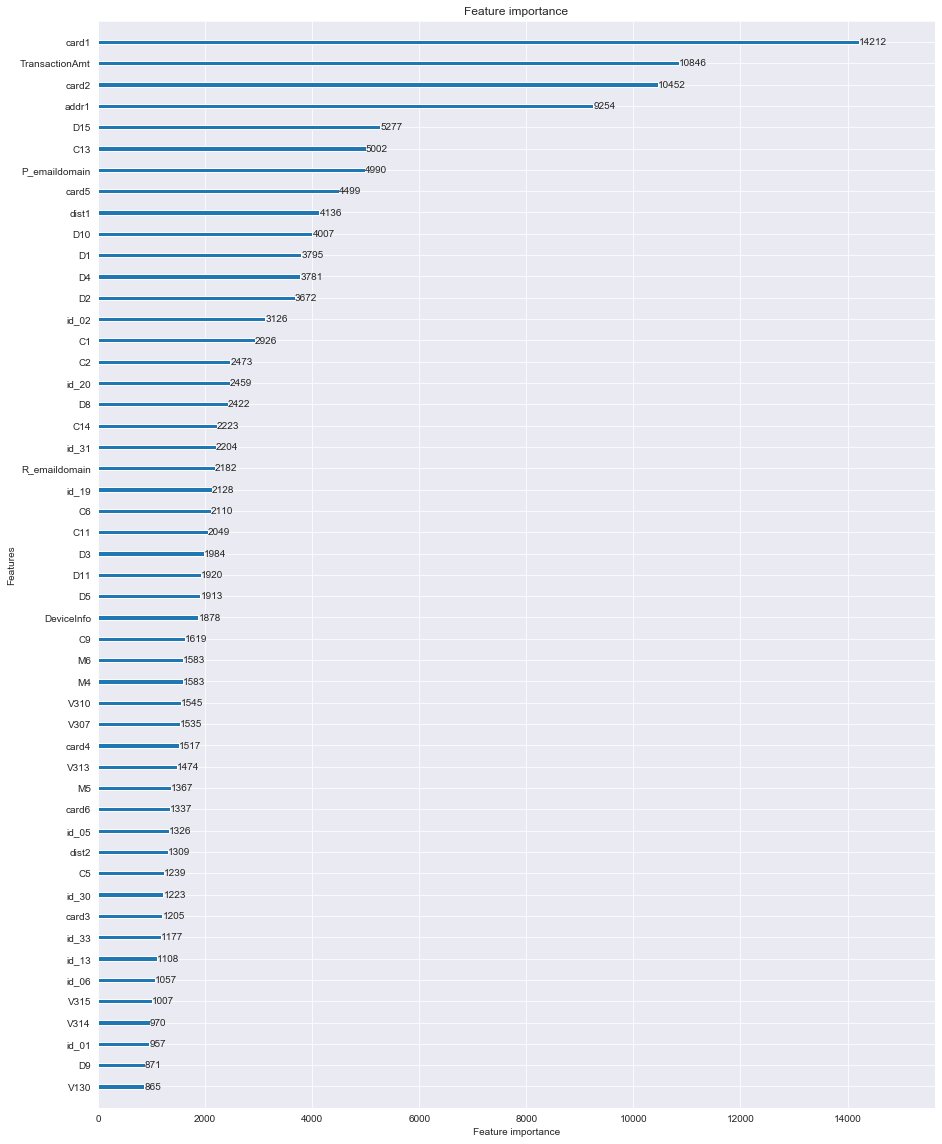

In [84]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [85]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_cv_dsample_shuffleF.csv')